In [1]:
%matplotlib inline
import geopandas as gpd
import pydeck as pdk
import shapely
from shapely.geometry import Polygon
from shapely.geometry import LineString, shape

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import plotly.express as px
import plotly.graph_objects as go

sns.set_style('whitegrid')

C:\Users\Soohee.samsung\Anaconda3\envs\r\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Matplotlib 한국어 세팅
import platform
from matplotlib import font_manager, rc

plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\malgun.ttf').get_name()
    rc('font', family=font_name)

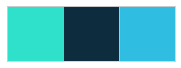

In [3]:
palette = ['#2fe1ca', '#0d2c3d','#2fbde1']
sns.palplot(palette)

# 0. 각종 함수 및 데이터 업로드

In [4]:
#pydeck 실행을 위해 geojson 파일의 좌표 처리
def polygon_to_coordinates(x):
    lon, lat = x.exterior.coords.xy
    return ([[x, y] for x, y in zip(lon, lat)])   
           
def multipolygon_to_coordinates(x):
    lon, lat = x[0].exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)]

def linestring_to_coordinates(line_string): 
    if isinstance(line_string, shapely.geometry.linestring.LineString): 
        lon, lat = line_string.xy 
        return [[x, y] for x, y in zip(lon, lat)] 
    elif isinstance(line_string, shapely.geometry.multilinestring.MultiLineString): 
        ret = [] 
        for i in range(len(line_string)): 
            lon, lat = line_string[i].xy 
            for x, y in zip(lon, lat): 
                ret.append([x, y]) 
        return ret

In [5]:
def MinMaxScale(df,feature, new_name):
    df[new_name] = df[feature].apply(lambda x: (x - df[feature].min()) / (df[feature].max() - df[feature].min()))

#동별 추이 보기 위한 스케일링
def ScaleByDong(df, dong, feature):
    df[feature+'추이'] = [0]*df.shape[0]
    for i in df[dong].unique():
        temp = df[df[dong]==i].copy()
        MinMaxScale(temp, feature, feature+'추이')
        ind = temp.index
        df.loc[ind, feature+'추이'] = temp[feature+'추이']

In [6]:
#추이 클러스터링
import scipy.cluster.hierarchy as spc

def hierarchical_clustering(correlation, method, param): 
    pdist = spc.distance.pdist(correlation)
    linkage = spc.linkage(pdist, method=method)
    idx = spc.fcluster(linkage, param * pdist.max(), 'distance')
    cluster = pd.DataFrame({'동':correlation.index, '그룹':idx})   
    
    return cluster

### 데이터(1):  34.행정경계(행정동기준).geojson

In [7]:
dong = gpd.read_file('data/34.행정경계(행정동기준).geojson')
dong.columns = ['동코드', '동', 'geometry']
dong['coordinates'] = dong['geometry'].apply(multipolygon_to_coordinates) 
dong = pd.DataFrame(dong)

In [8]:
from area import area

면적 = []
for i in list(range(dong.shape[0])):
    coord = {'type':'Polygon', 'coordinates': [dong['coordinates'][i]]}
    면적.append(area(coord)/1e+6)
    
dong['면적km2'] = 면적

### 데이터(2): 02.자전거스테이션.csv

In [9]:
station = pd.read_csv('data/02.자전거스테이션.csv')

In [10]:
# 자전거 스테이션이 어떤 동에 있는지 출력하는 코드
# 자전거 스테이션의 좌표가 어떤 행정동의 Polygon 안에 있는지 출력 
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from tqdm import tqdm

def get_point_isin_which_dong(Data_point_input, Data_dong_input):
    Data_point = Data_point_input.copy()
    Data_dong  = Data_dong_input.copy()
    
    dong_contain = []
    
    for i in tqdm(range(0, len(Data_point))):
        for idx, coord in enumerate(Data_dong['geometry']):
            
            if coord.contains(Point(Data_point[['경도','위도']].values[i])):
                dong_contain.append(Data_dong.loc[idx, "동"])
                
    return dong_contain

In [11]:
station['동']= get_point_isin_which_dong(station, dong)
station.head()

100%|████████████████████████████████████████| 164/164 [00:05<00:00, 29.55it/s]


,Station_ID,STATION_NAME,거치대 수량,위도,경도,동
0,101,어울림마을 701동 앞,20,37.654775,126.834584,성사2동
1,103,대림e-편한세상106동,20,37.660442,126.840377,성사1동
2,104,탄현마을8단지,25,37.698523,126.766042,탄현동
3,105,KT 덕양지사 앞,20,37.655244,126.839261,성사1동
4,106,원당역 앞 공영주차장,30,37.653410,126.842530,성사1동


### 데이터(3): 07.인구통계.csv

In [12]:
pop = pd.read_csv('data/07.인구통계.csv')

pop['행정 코드'] = pop['행정구역'].apply(lambda x: x[-11:-1])
pop['행정구역'] = pop['행정구역'].apply(lambda x: x[:-12])
pop['총인구수'] = pop['총인구수'].str.replace(r'[,]', "").astype('int')
pop['년도'] = pop['조회기준'].apply(lambda x: x[:4]).astype('int')
pop['월'] = pop['조회기준'].apply(lambda x: x[5:7]).astype('int')
pop['조회기준'] = pop['조회기준'].apply(lambda x: x[:4]+'-'+x[5:7])

In [13]:
ind_신도동 = list(pop[(pop['행정구역']=='경기도 고양시 덕양구 신도동') & (pop['총인구수']==0)].index)
ind_삼송동 = list(pop[(pop['행정구역']=='경기도 고양시 덕양구 삼송동') & (pop['총인구수']==0)].index)
pop = pop[~pop.index.isin(ind_신도동 + ind_삼송동)]
pop.loc[pop['행정구역']=='경기도 고양시 덕양구 신도동', '행정구역'] = '경기도 고양시 덕양구 삼송동'

In [14]:
pop = pop[~pop['행정구역'].isin(['경기도 고양시 ', '경기도 고양시 일산서구 ', '경기도 고양시 일산동구 ', '경기도 고양시 덕양구 '])].reset_index(drop=True)
pop['동'] = pop['행정구역'].apply(lambda x: x.split(' ')[-1])

### 데이터(4): 06.인구(거주)분포도(100M X 100M).geojson

In [15]:
pop_dist = gpd.read_file('data/06.인구(거주)분포도(100M X 100M).geojson')
pop_dist = pop_dist.dropna()
pop_dist['coordinates'] = pop_dist['geometry'].apply(multipolygon_to_coordinates) 
del pop_dist['geometry']
pop_dist = pd.DataFrame(pop_dist)
pop_dist['val_sc'] = (pop_dist['val']-pop_dist['val'].min()) / (pop_dist['val'].max()-pop_dist['val'].min())

### 데이터(5): 01.운영이력.csv

In [16]:
operate = pd.read_csv("data/01.운영이력.csv")
operate = operate.rename(columns={'LEAS_NO':'대여 번호','LEAS_DATE': '대여 시간',
                                 'LEAS_STATION':'대여 스테이션 번호','LEAS_DEF_NO':'대여 거치대 번호',
                                 'RTN_DATE':'반납 시간', 'RTN_STATION':'반납 스테이션 번호',
                                 'RTN_DEF_NO':'반납 거치대 번호', 'TRNV_QTY':'추정 이동 거리',
                                 'MEMB_DIV':'회원 구분', 'MEMB_NO':'회원 번호',
                                 'TEMP_MEMB_NO':'비회원 번호', 'BIKE_TAG':'자전거 번호'})
operate.drop(['LEAS_STAT'], axis=1, inplace=True)

C:\Users\Soohee.samsung\Anaconda3\envs\r\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
operate['대여 시간'] = pd.to_datetime(operate['대여 시간'], errors='coerce')
operate['반납 시간'] = pd.to_datetime(operate['반납 시간'], errors='coerce')

operate = operate[operate['대여 스테이션 번호']!=998].reset_index(drop=True)

In [18]:
#대여 스테이션이 어느 동에 있는지, 반납 스테이션이 어느 동에 있는지 칼럼 생성.
station_대여 = station[['Station_ID', '동']].copy()
station_대여.columns = ['대여 스테이션 번호', '대여 동']
operate = pd.merge(operate, station_대여, on='대여 스테이션 번호', how='left')

station_반납 = station[['Station_ID', '동']].copy()
station_반납.columns = ['반납 스테이션 번호', '반납 동']
operate = pd.merge(operate, station_반납, on='반납 스테이션 번호', how='left')

In [19]:
operate['대여_년도'] = operate['대여 시간'].dt.year
operate['대여_월'] = operate['대여 시간'].dt.month
operate['대여_시'] = operate['대여 시간'].dt.hour
operate['대여_분'] = operate['대여 시간'].dt.minute

### 데이터(6) : 14.고양시 지적도.geojson

In [20]:
cadastre = gpd.read_file('data/14.고양시 지적도.geojson')
cadastre['coordinates'] = cadastre['geometry'].apply(multipolygon_to_coordinates) 
del cadastre['geometry']
cadastre = pd.DataFrame(cadastre)

In [21]:
cadastre['지목'] = cadastre['JIBUN'].apply(lambda x: x[-1:])
park = cadastre[cadastre['지목']=='공'].reset_index(drop=True)
river = cadastre[cadastre['지목']=='천'].reset_index(drop=True)
school = cadastre[cadastre['지목']=='학'].reset_index(drop=True)

### 데이터(7): 33.고양시_인도.geojson

In [22]:
path = gpd.read_file('data/33.고양시_인도.geojson')
path['coordinates'] = path['geometry'].apply(linestring_to_coordinates) 
del path['geometry']
path = pd.DataFrame(path)

In [23]:
# 자전거 도로가 존재하는 인도, 자전거 도로가 존재하지 않는 인도, 자전거 도로 3가지로 분류.
color_list = [[0,250,10,170], [250,50,0,170], [0,150,240, 170]]
path['색상'] = [0]*path.shape[0]

for i, j, col in zip(['BYC001', 'BYC001', 'BYC002'], ['SWK001', 'SWK002', 'SWK001'], color_list):
    temp = path[(path['자전거도로유/무']==i) & (path['종류']==j)].copy()
    ind = temp.index
    temp['색상'] = [col]*temp.shape[0]
    path.loc[ind,'색상'] = temp['색상']

### 데이터(8): 20.고양시 버스정류소.csv

In [24]:
bus = pd.read_csv('data/20.고양시 버스정류소.csv')
bus.columns=['역이름','ID','경도','위도']

### 데이터(9): 21.버스 정류장별 승하차 정보.csv

In [25]:
bus_info = pd.read_csv('data/21.버스 정류장별 승하차 정보.csv')
bus_info.columns = ['ID','역이름','승하차']

temp = bus_info.groupby('ID').sum().reset_index()
bus_info = pd.merge(temp, bus_info.iloc[:,:2].drop_duplicates(), on='ID', how='left')

In [26]:
#버스 정류장 별 승하차 정보 추가
bus = pd.merge(bus_info, bus.iloc[:,1:], on='ID', how='left')
bus = bus.dropna().reset_index(drop=True)

### 데이터(10): 19.전철역_공간정보.csv

In [27]:
subway = pd.read_csv('data/19.전철역_공간정보.csv')
subway.columns = ['호선','역이름','지번주소','도로명주소','경도','위도']
subway['역이름'] = subway['역이름'].apply(lambda x: '화전' if x=='화전(한국항공대)' else '지축' if x=='지축역' else x)

In [28]:
# 3호선과 경의중앙선 루트
subway_3호선 = subway[subway['호선']=='3호선'].sort_values(by=['경도','위도'])[['경도','위도']].values.tolist()
subway_경의중앙 = subway[subway['호선']=='경의중앙'].sort_values(by=['경도','위도'])[['경도','위도']].values.tolist()

subway_route = pd.DataFrame([['3호선',subway_3호선],['경의중앙',subway_경의중앙]],  columns=['호선','path'])
subway_route['color'] = [[250,120,50,150], [50,180,230,150]]

### 데이터(11): 29.지하철 역별 이용객수.csv

In [29]:
subway_info = pd.read_csv('data/29.지하철 역별 이용객수.csv')
subway_info = subway_info[['호선명','역명','승하차구분','모든요일_합계']]
subway_info = subway_info[subway_info['승하차구분']=='총승하차'].reset_index(drop=True).drop('승하차구분',axis=1)
subway_info.columns=['호선','역이름', '승하차']

In [30]:
subway_info['호선'] = subway_info['호선'].apply(lambda x: '3호선' if x=='일산선' else '경의중앙' if x=='경의선' else x)
subway_info = subway_info.groupby(['호선','역이름']).mean().reset_index()

In [31]:
#역별 승하차 정보 추가
subway = pd.merge(subway[['호선','역이름','경도','위도']], subway_info, on=['호선','역이름'], how='left').fillna(0)
subway = pd.merge(subway,subway_route[['호선','color']], on='호선',how='left')

---

In [32]:
# pydeck plot에서 매번 등장할 레이어
dong_map = pdk.Layer('PolygonLayer', dong, get_polygon='coordinates', pickable=True, auto_highlight=True,
                     get_fill_color='[100,150,200,30]',
                     get_line_color='[255, 255, 255]',
                     lineWidthScale=11)

center =[126.811544, 37.654908]
view_state = pdk.ViewState(longitude=center[0], latitude=center[1], zoom=11)

# 1. 현황 및 불만 파악

## 1.1. 자전거 스테이션 입지 및 이용 현황

In [33]:
park_map = pdk.Layer('PolygonLayer', park, get_polygon='coordinates', pickable=True, auto_highlight=True,
                     get_fill_color='[130, 250, 200, 190]',
                     get_line_color='[255, 255, 255]',
                     lineWidthScale=3,)

school_map = pdk.Layer('PolygonLayer', school, get_polygon='coordinates', pickable=True, auto_highlight=True,
                       get_fill_color='[230, 230, 20, 190]',
                       get_line_color='[255, 255, 255]',
                       lineWidthScale=3,)

subway_route_map = pdk.Layer('PathLayer', subway_route, get_path='path', pickable=True, auto_highlight=True,
                             get_color='color', 
                             get_width=5,
                             width_scale=20,
                             width_min_pixels=2,)

station_map = pdk.Layer('ScatterplotLayer', station, pickable=True, auto_highlight=True,
                        get_position=['경도', '위도'],
                        get_fill_color=[250, 250, 250],
                        get_line_color=[0, 0, 0],
                        opacity=0.3,
                        radius_min_pixels=5,
                        stroked=True,
                        line_width_min_pixels=1)

r = pdk.Deck(layers=[dong_map, park_map, school_map, subway_route_map, station_map], initial_view_state=view_state)
#r.to_html('기타 중간 결과물/스테이션 이용 현황.html')
r.show()

DeckGLWidget(google_maps_key=None, json_input='{"initialViewState": {"latitude": 37.654908, "longitude": 126.8…

In [34]:
pop_dist_map = pdk.Layer('PolygonLayer', pop_dist, get_polygon='coordinates', pickable=True, auto_highlight=True,
                         get_fill_color='[57,240,200,200]',
                         get_line_color='[255,255,255]',
                         lineWidthScale=1,
                         extruded=True,
                         get_elevation='val'
                        )

view_state_3D = pdk.ViewState(longitude=center[0],latitude=center[1], pitch=30,zoom=11)

r = pdk.Deck(layers=[dong_map, pop_dist_map], initial_view_state=view_state_3D)
#r.to_html('기타 중간 결과물/인구분포도(100x100).html')
r.show()

DeckGLWidget(google_maps_key=None, json_input='{"initialViewState": {"latitude": 37.654908, "longitude": 126.8…

In [35]:
import math
bus["radius"] = bus["승하차"].apply(lambda exits_count: math.sqrt(exits_count))
subway["radius"] = subway["승하차"].apply(lambda exits_count: math.sqrt(exits_count))

In [36]:
bus_info_map = pdk.Layer('ScatterplotLayer', bus, get_position=['경도', '위도'], pickable=True, auto_highlight=True,
                         get_fill_color=[57,240,200, 180], 
                         get_line_color=[0, 0, 0],
                         opacity=0.3,
                         stroked=True,
                         radius_scale=1,
                         radius_min_pixels=2,
                         radius_max_pixels=13,
                         line_width_min_pixels=1,
                         get_radius="radius",
                        )

subway_info_map = pdk.Layer('ScatterplotLayer', subway, get_position=['경도', '위도'], pickable=True, auto_highlight=True,
                            get_fill_color='color',
                            get_line_color=[0, 0, 0],
                            opacity=0.3,
                            stroked=True,
                            radius_scale=1,
                            radius_min_pixels=2,
                            radius_max_pixels=13,
                            line_width_min_pixels=1,
                            get_radius="radius",
                           )

r = pdk.Deck(layers=[dong_map, bus_info_map, subway_info_map, subway_route_map], initial_view_state=view_state)
#r.to_html("기타 중간 결과물/버스와 지하철.html")
r.show()

DeckGLWidget(google_maps_key=None, json_input='{"initialViewState": {"latitude": 37.654908, "longitude": 126.8…

### 이용 현황

In [37]:
대여추이 = operate.groupby('대여_년도').count()['대여 번호'].reset_index().rename(columns={'대여 번호': '전체 대여 수'})
대여추이['반납 제대로 안 된 수'] = operate[operate['반납 스테이션 번호']==0].groupby('대여_년도').count().reset_index()['대여 번호']
대여추이['반납 제대로 안 된 비율'] = np.round(대여추이['반납 제대로 안 된 수']/ 대여추이['전체 대여 수']*100,1)
대여추이

,대여_년도,전체 대여 수,반납 제대로 안 된 수,반납 제대로 안 된 비율
0,2017,1189645,107810,9.1
1,2018,972135,120809,12.4
2,2019,980883,169611,17.3


In [38]:
대여추이 = pd.melt(대여추이[['대여_년도','전체 대여 수','반납 제대로 안 된 수']], id_vars = ['대여_년도'])

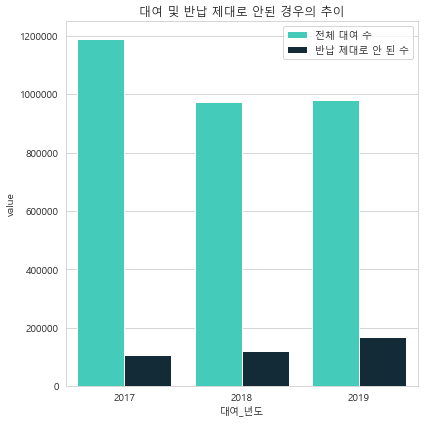

In [39]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sns.barplot('대여_년도','value', hue='variable', data=대여추이, ax=ax, palette=palette)
ax.set_title('대여 및 반납 제대로 안된 경우의 추이',fontsize=12)
ax.legend(fontsize=10)
plt.tight_layout()

---

## 1.2. 불만 상황 파악

## (1) 떠오르는 지역들에는 스테이션이 없다

### 각 동의 2017년 대비 2019년의 총인구수

In [40]:
pop_2017 = pop[pop['조회기준'] == '2017-01'].reset_index(drop=True)
pop_2019 = pop[pop['조회기준'] == '2019-12'].reset_index(drop=True)
pop_2017['17년 대비 19년 인구증감률'] = np.array(pop_2019['총인구수'])/np.array(pop_2017['총인구수'])

동별인구증감 = pd.merge(dong, pop_2017[['동', '17년 대비 19년 인구증감률']], on='동', how='left')
동별인구증감['인구증감률_보정'] = 동별인구증감['17년 대비 19년 인구증감률']**3

In [41]:
pop_increase_rate = pdk.Layer('PolygonLayer', 동별인구증감, get_polygon='coordinates', pickable=True, auto_highlight=True,
                              get_fill_color='[0, 170*인구증감률_보정, 150*인구증감률_보정, 170]',
                              get_line_color='[250,250,250,200]',
                              get_line_width =15,
                             ) 

r = pdk.Deck(layers=[dong_map, pop_increase_rate], initial_view_state=view_state)
#r.to_html("기타 중간 결과물/각 동의 2017년 대비 2019년의 총인구수.html")
r.show()

DeckGLWidget(google_maps_key=None, json_input='{"initialViewState": {"latitude": 37.654908, "longitude": 126.8…

### 각 동의 2017년 대비 2019년의 대여 건수

In [42]:
lend = operate.groupby(['대여 동','대여_년도']).count()['대여 번호'].reset_index()
lend.columns = ['행정구역','년도', '대여건수']

lend = lend[lend['행정구역']!='장항1동'] #2019년에 생겼음.

In [43]:
대여건수_2017 = lend[lend['년도']==2017].reset_index(drop=True)
대여건수_2019 = lend[lend['년도']==2019].reset_index(drop=True)

대여건수_비교 = 대여건수_2017[['행정구역']].copy()
대여건수_비교['17년 대비 19년 대여증감률'] = 대여건수_2019['대여건수']/대여건수_2017['대여건수']
대여건수_비교['대여증감률_보정'] = 대여건수_비교['17년 대비 19년 대여증감률']**3
대여건수_비교 = pd.merge(대여건수_비교, dong[['동','coordinates']], left_on='행정구역', right_on='동', how='left')

In [44]:
lend_increase_rate = pdk.Layer('PolygonLayer', 대여건수_비교, get_polygon='coordinates', pickable=True, auto_highlight=True,
                              get_fill_color='[0, 150*대여증감률_보정,170*대여증감률_보정,230]',
                              get_line_color='[250,250,250,200]',
                              get_line_width =15,
                             )

r = pdk.Deck(layers=[dong_map, lend_increase_rate], initial_view_state=view_state)
#r.to_html("기타 중간 결과물/각 동의 2017년 대비 2019년의 대여건수.html")
r.show()

DeckGLWidget(google_maps_key=None, json_input='{"initialViewState": {"latitude": 37.654908, "longitude": 126.8…

In [45]:
pop_cluster = pop[['동','조회기준', '총인구수']].copy()
cor = pd.pivot(pop_cluster, index='조회기준', columns='동', values='총인구수').corr()
인구추이_클러스터 = hierarchical_clustering(cor, 'complete', 0.4) #계층적 군집화

pop_cluster = pd.merge(pop_cluster, 인구추이_클러스터, on='동', how='left')
pop_cluster['그룹'] = pop_cluster['그룹'].apply(lambda x: '감소' if x==1 else '증가') #그룹1이면 증가추세, 2이면 감소추세
ScaleByDong(pop_cluster,'동','총인구수') #동별로 MinMax스케일링

pop_cluster[['동','그룹']].drop_duplicates()['그룹'].value_counts()

감소    23
증가    16
Name: 그룹, dtype: int64

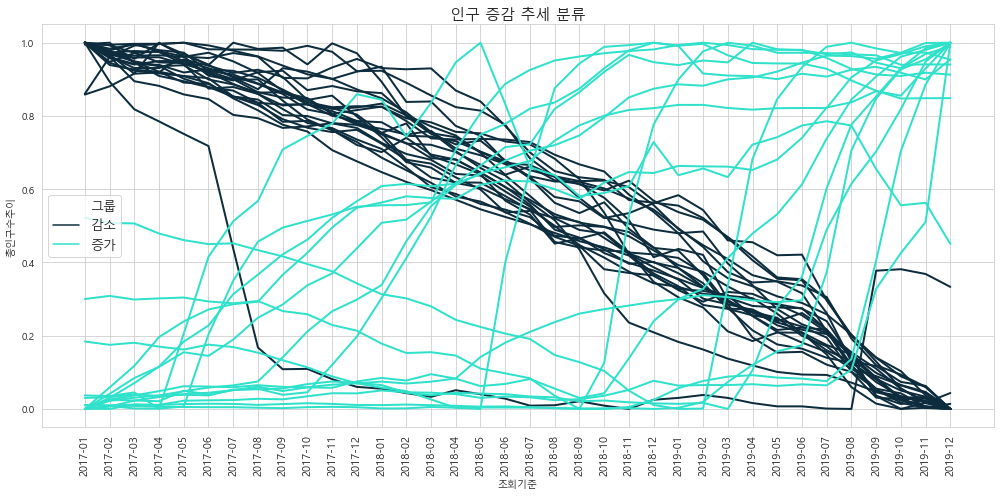

In [46]:
fig,ax = plt.subplots(1,1,figsize=(14,7))

sns.lineplot(x='조회기준', y='총인구수추이', hue='그룹', units='동', estimator=None,  data=pop_cluster, ax=ax,
            palette=[palette[1], palette[0]], linewidth=2)
ax.set_xticklabels(pop_cluster['조회기준'].unique(), rotation=90, fontsize=11)
ax.set_title('인구 증감 추세 분류', fontsize=15)
ax.legend(fontsize=13)
plt.tight_layout()

In [47]:
동별_스테이션_개수 = station['동'].value_counts().reset_index()
동별_스테이션_개수.columns = ['동','기존 스테이션 개수']

동별_정보 = pd.merge(dong[['동','면적km2']], 동별_스테이션_개수, on='동', how='left').fillna(0)
동별_정보['면적 대비 개수'] = 동별_정보['기존 스테이션 개수']/ 동별_정보['면적km2']
동별_정보['면적 대비 개수_분류'] = 동별_정보['면적 대비 개수'].apply(lambda x: '1이상' if x>=1 else '1미만')

In [48]:
동별_정보 = pd.merge(동별_정보, 인구추이_클러스터, on='동', how='left')
동별_정보['인구 증감_분류'] = 동별_정보['그룹'].apply(lambda x: '감소' if x==1 else '증가')
del 동별_정보['그룹']

In [49]:
#플랏 위에 비율 출력하기 위한 함수
def Find_TextLocation(df):
    location_df = df.copy()
    for i in range(len(df.columns)):
        location_df.iloc[:,i] = df.iloc[:,:i].sum(axis=1) + df.iloc[:, i]/2
    
    return location_df

def TextPercent(temp, texts, labels):
    y_location = np.repeat(list(labels), temp.shape[1])
    x_location = Find_TextLocation(temp)
    x_location = x_location.values.reshape(-1)
    
    for y, x, prop in zip(y_location, x_location, texts):
        ax.text(x, y, str(prop)+'%', ha='center', va='center', color='white', weight='bold', fontsize=13)

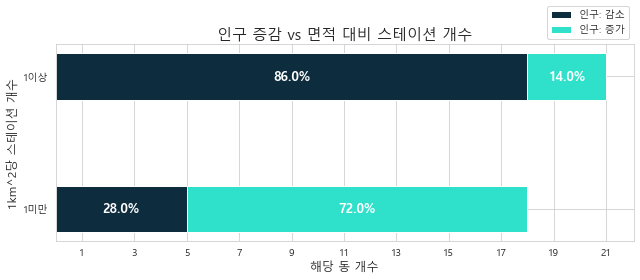

In [50]:
temp = pd.pivot(동별_정보.groupby(['면적 대비 개수_분류', '인구 증감_분류']).count()['동'].reset_index(), 
         index='면적 대비 개수_분류', columns='인구 증감_분류', values='동')
labels = temp.index
width = 0.35     

fig, ax = plt.subplots(figsize=(9,4))

ax.barh(labels, temp['감소'], width, label='인구: 감소', color=palette[1])
ax.barh(labels, temp['증가'], width, left=temp['감소'], label='인구: 증가', color=palette[0])

texts = round(temp/temp.sum(axis=1).values.reshape(-1,1)*100).values.reshape(-1)
TextPercent(temp, texts, labels)
ax.set_xlabel('해당 동 개수', fontsize=12)
ax.set_ylabel('1km^2당 스테이션 개수', fontsize=12)
ax.set_title('인구 증감 vs 면적 대비 스테이션 개수', fontsize=15)
ax.legend(bbox_to_anchor=(1,1), loc='lower right')
ax.set_xticks(list(range(1,22,2)))
plt.tight_layout()

In [51]:
동별_정보 = pd.merge(동별_정보, 대여건수_비교[['동', '17년 대비 19년 대여증감률']], on='동', how='left').fillna(0)
동별_정보['대여 증감_분류'] = 동별_정보['17년 대비 19년 대여증감률'].apply(lambda x: '증가' if x>1. else '감소' if x>0 else '스테이션 없었음')

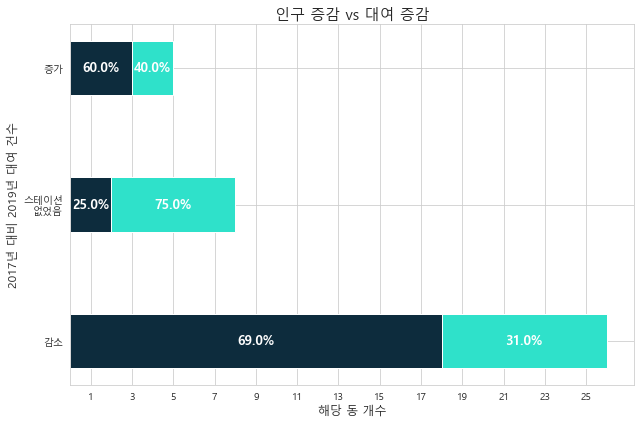

In [52]:
temp = pd.pivot(동별_정보.groupby(['대여 증감_분류', '인구 증감_분류']).count()['동'].reset_index(),
         index='대여 증감_분류', columns='인구 증감_분류', values='동')
labels = ['감소', '스테이션\n없었음', '증가']
width = 0.4     

fig, ax = plt.subplots(figsize=(9,6))

ax.barh(labels, temp['감소'], width, label='인구: 감소', color=palette[1])
ax.barh(labels, temp['증가'], width, left=temp['감소'], label='인구: 증가', color=palette[0])

texts = round(temp/temp.sum(axis=1).values.reshape(-1,1)*100).values.reshape(-1)
TextPercent(temp, texts, labels)

ax.set_xlabel('해당 동 개수', fontsize=12)
ax.set_ylabel('2017년 대비 2019년 대여 건수', fontsize=12)
ax.set_title('인구 증감 vs 대여 증감', fontsize=15)
ax.set_xticks(list(range(1,26,2)))
plt.tight_layout()

### 하천과 자전거길

In [53]:
path_map = pdk.Layer('PathLayer', path, get_path='coordinates', pickable=True, auto_highlight=True, 
                     get_width = 9,
                     get_color='색상'
                    ) 

river_map = pdk.Layer('PolygonLayer', river, get_polygon='coordinates', pickable=True, auto_highlight=True, 
                  get_fill_color='[130, 150, 250, 190]',
                  get_line_color='[255, 255, 255]',
                  lineWidthScale=3,
                 )

r = pdk.Deck(layers=[dong_map, river_map, path_map], initial_view_state=view_state)
#r.to_html("기타 중간 결과물/하천과 자전거길.html")
r.show()

DeckGLWidget(google_maps_key=None, json_input='{"initialViewState": {"latitude": 37.654908, "longitude": 126.8…

## (2) 같은 시간에 같은 목적으로 탄다

In [54]:
#동별로 하루 각 시간대의 대여건수-반납건수를 구한다.
동별_시간대 = pd.DataFrame()

for year in [2017,2018,2019]:
    operate_year = operate[operate['대여_년도']==year].copy()
    
    for i in list(range(24)):
        temp = operate_year[operate_year['대여_시']==i].copy()
        lend_station = temp['대여 동'].value_counts().reset_index()
        lend_station.columns = ['동', '대여 건수']
        return_station = temp['반납 동'].value_counts().reset_index()
        return_station.columns = ['동', '반납 건수']
        
        temp2 = pd.merge(lend_station, return_station, on='동', how='left')
        temp2['대여-반납'] = temp2['대여 건수']-temp2['반납 건수']
        temp2['시간'] = [i]*temp2.shape[0]
        
        temp2['년도'] = [year]*temp2.shape[0]
        동별_시간대 = pd.concat([동별_시간대, temp2])

동별_시간대 = 동별_시간대.sort_values(by=['년도','동','시간'])
동별_시간대 = 동별_시간대.reset_index(drop=True)

In [55]:
동별_시간대

,동,대여 건수,반납 건수,대여-반납,시간,년도
0,능곡동,169,288,-119,0,2017
1,능곡동,176,186,-10,1,2017
2,능곡동,74,125,-51,2,2017
3,능곡동,33,45,-12,3,2017
4,능곡동,22,28,-6,4,2017
...,...,...,...,...,...,...
2250,흥도동,966,708,258,19,2019
2251,흥도동,803,640,163,20,2019
2252,흥도동,796,640,156,21,2019
2253,흥도동,803,825,-22,22,2019


In [56]:
동별_시간대 = 동별_시간대.groupby(['동','시간']).mean().reset_index().drop('년도', axis=1)
ScaleByDong(동별_시간대, '동', '대여-반납')

#조금 로버스트한 트렌드를 보기 위해 이동평균 변수 추가
동별_시간대['대여-반납추이_MA'] = 동별_시간대.groupby('동').rolling(window=2, min_periods=1).mean().reset_index()['대여-반납추이']

In [57]:
cor = pd.pivot(동별_시간대, index='시간', columns='동', values='대여-반납').corr()
동별_시간대_클러스터 = hierarchical_clustering(cor, 'complete', 0.6) #대여-반납 하루 추이의 계층적 군집화
동별_시간대_클러스터['그룹'].value_counts()

4    14
1     8
2     7
3     3
Name: 그룹, dtype: int64

In [58]:
# 트렌드 플롯 함수
def plot_trend(그룹, color='#ff4e0a', title='title'):
    
    cluster_kind = list(동별_시간대_클러스터[동별_시간대_클러스터['그룹']==그룹]['동'])
    temp = 동별_시간대[동별_시간대['동'].isin(cluster_kind)]
    num_category = len(cluster_kind)
    
    fig, ax = plt.subplots(1,1, figsize=(14,5))
    sns.lineplot(x='시간', y='대여-반납추이_MA', data=temp, hue='동',marker='>',linewidth=2, 
                palette=sns.light_palette("gray", num_category), ax=ax)
    sns.lineplot(x='시간', y='대여-반납추이_MA', data=temp, ci='sd', color=color, alpha=0.1, ax=ax)
    
    plt.title(title,fontsize=15)
    plt.ylabel('대여-반납 추이', fontsize=12)
    ax.legend(loc='lower right', frameon=False, bbox_to_anchor=(1.11, 0.05), fontsize=11)
    plt.xlabel('시간', fontsize=12)
    plt.xticks(list(range(24)))
    plt.tight_layout()

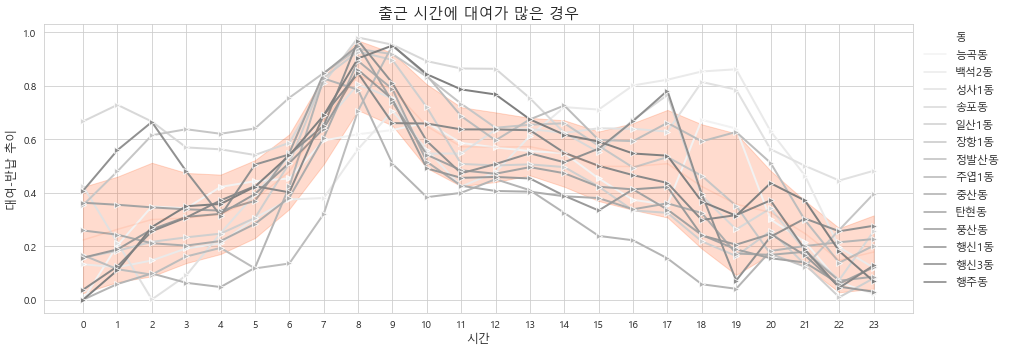

In [59]:
plot_trend(4, title='출근 시간에 대여가 많은 경우')

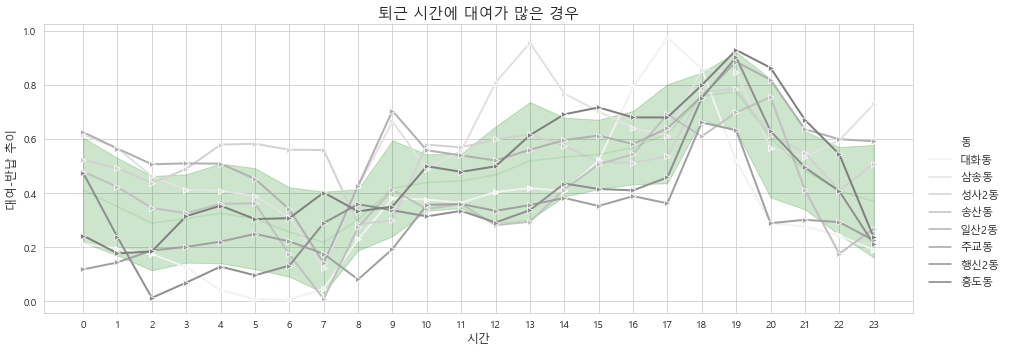

In [60]:
plot_trend(1, 'green', '퇴근 시간에 대여가 많은 경우')

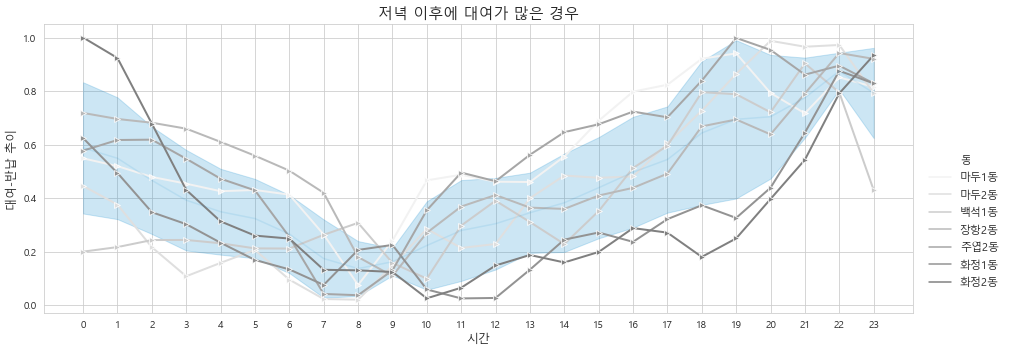

In [61]:
plot_trend(2, '#0486cc', '저녁 이후에 대여가 많은 경우')

In [62]:
# 위 세 경우에 해당하는 행정동들을 지도에 나타내보자
동별_시간대_클러스터 = 동별_시간대_클러스터[동별_시간대_클러스터['그룹']!=3]
동별_시간대_클러스터2 = pd.merge(동별_시간대_클러스터, dong[['동', 'coordinates']], on='동', how='left')
동별_시간대_클러스터2['color'] = 동별_시간대_클러스터2['그룹'].apply(lambda x: [255, 162, 125,100] if x==4 else [147, 217, 153,100] if x==1 else [140, 186, 255,100])

In [63]:
dong_cluster = pdk.Layer('PolygonLayer', 동별_시간대_클러스터2, get_polygon='coordinates', 
                         get_fill_color='color',
                         get_line_color='[250,250,250,200]',
                         get_line_width =15,
                        ) 

subway_3_map = pdk.Layer('PathLayer', subway_route[subway_route['호선']=='3호선'], get_path='path', 
                         get_color='color', 
                         get_width=10,
                         width_scale=20
                        )

r = pdk.Deck(layers=[dong_map, dong_cluster, subway_3_map, park_map], initial_view_state=view_state)
#r.to_html("기타 중간 결과물/동별 자전거 이용 목적.html")
r.show()

DeckGLWidget(google_maps_key=None, json_input='{"initialViewState": {"latitude": 37.654908, "longitude": 126.8…

### 평균 탑승 시간

In [64]:
평균탑승시간 = operate[['대여 동', '반납 동', '대여 시간', '반납 시간']].copy()
평균탑승시간['hour'] = 평균탑승시간['대여 시간'].dt.hour
평균탑승시간['총시간'] = 평균탑승시간['반납 시간']  - 평균탑승시간['대여 시간'] 

In [65]:
그룹별_평균시간 = pd.DataFrame()

for i in 동별_시간대_클러스터['그룹'].unique():
    cluster_kind = list(동별_시간대_클러스터[동별_시간대_클러스터['그룹']==i]['동'])
    temp = 평균탑승시간[평균탑승시간['대여 동'].isin(cluster_kind)]
    mean_time = []
    
    for time in list(range(24)):
        mean_time.append(temp[temp['hour']==time]['총시간'].mean())
    
    그룹별_평균시간[i] = mean_time

그룹별_평균시간.columns = ['출근 시간에 대여가 많은 경우', '퇴근 시간에 대여가 많은 경우', '저녁 이후에 대여가 많은 경우']

In [66]:
시간대_추이 = 그룹별_평균시간.mean(axis=0).reset_index()
시간대_추이.columns = ['시간대 추이', '평균 소요 시간']
시간대_추이['최대 소요 시간'] = 그룹별_평균시간.max(axis=0).values
시간대_추이

,시간대 추이,평균 소요 시간,최대 소요 시간
0,출근 시간에 대여가 많은 경우,0 days 00:23:21.480610502,0 days 00:27:59.609384023
1,퇴근 시간에 대여가 많은 경우,0 days 00:25:35.952945535,0 days 00:31:02.371944514
2,저녁 이후에 대여가 많은 경우,0 days 00:26:08.671942352,0 days 00:34:26.181689359
